In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="darkgrid", color_codes=True)

import statsmodels.api as sm

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import logging
logging.disable(logging.CRITICAL)

In [ ]:
!pip install darts
from darts import TimeSeries, concatenate
from darts.dataprocessing.transformers import Scaler
from darts.models import TFTModel
from darts.metrics import mae
from darts.metrics import mape
from darts.metrics import mse
from darts.metrics import rmse
from darts.utils.statistics import check_seasonality, plot_acf
from darts.utils.timeseries_generation import datetime_attribute_timeseries
from darts.utils.likelihood_models import QuantileRegression
from darts.explainability.tft_explainer import TFTExplainer

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 817.6/817.6 kB 5.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 12.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 160.5/160.5 kB 18.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 533.5/533.5 kB 18.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 118.1/118.1 kB 15.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.0/44.0 kB 5.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 777.7/777.7 kB 20.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.7/101.7 kB 13.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 840.2/840.2 kB 23.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 279.8/279.8 kB 26.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.4/60.4 kB 8.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 169.2/169.2

In [ ]:
df = pd.read_excel("ASIALNG.xlsx")
df['DATE'] = pd.to_datetime(df['DATE'])
df.set_index('DATE', inplace=True)
df

,ASIALNG,ASIALNG_LAG1,ASIALNG_LAG2,ASIALNG_LAG3,ASIALNG_LAG4,USAGDP,Equity Market Volatility,3 Month Treasury Bill,Infectious Disease Tracker,COV19,RUWAR
DATE,,,,,,,,,,,
1996-07-01,0.002621,0.023906,0.081163,0.000000,-0.099806,0.020675,-4.19,0.09,-0.196710,0,0
1996-10-01,0.109019,0.002621,0.023906,0.081163,0.000000,0.012196,1.94,0.08,0.083382,0,0
1997-01-01,0.002345,0.109019,0.002621,0.023906,0.081163,0.015662,-0.40,-0.12,-0.446287,0,0
1997-04-01,-0.143281,0.002345,0.109019,0.002621,0.023906,0.012380,2.70,0.08,0.782759,0,0
1997-07-01,-0.061301,-0.143281,0.002345,0.109019,0.002621,0.018502,-0.41,-0.01,0.041964,0,0
...,...,...,...,...,...,...,...,...,...,...,...
2022-07-01,0.553581,-0.148651,-0.112020,0.644932,0.604677,0.020373,-0.43,0.77,-0.083527,1,1
2022-10-01,-0.491094,0.553581,-0.148651,-0.112020,0.644932,0.017477,-3.25,1.58,-0.269102,1,1
2023-01-01,-0.538396,-0.491094,0.553581,-0.148651,-0.112020,0.015792,1.58,1.38,0.005921,1,1


In [ ]:
selected_columns = ["ASIALNG","ASIALNG_LAG1"]
pruned_df = df[selected_columns]

pruned_df = pruned_df.set_index(df.index)
pruned_df

,ASIALNG,ASIALNG_LAG1
DATE,,
1996-07-01,0.002621,0.023906
1996-10-01,0.109019,0.002621
1997-01-01,0.002345,0.109019
1997-04-01,-0.143281,0.002345
1997-07-01,-0.061301,-0.143281
...,...,...
2022-07-01,0.553581,-0.148651
2022-10-01,-0.491094,0.553581
2023-01-01,-0.538396,-0.491094


## Create Darts Series for Pandas DF

In [ ]:
# Convert the DataFrame to a TimeSeries object
series = TimeSeries.from_dataframe(pruned_df, value_cols='ASIALNG')
series = series.astype(np.float32)

### Splitting

In [ ]:
# Create training and validation sets:
training_cutoff = pd.Timestamp("20210701")
train, val = series.split_after(training_cutoff)

### Normalization

In [ ]:
# Normalize the time series (note: we avoid fitting the transformer on the validation set)
transformer = Scaler()
train_transformed = transformer.fit_transform(train)
val_transformed = transformer.transform(val)
series_transformed = transformer.transform(series)

### Create Covariates

In [ ]:
# create year, month and integer index covariate series
covariates = datetime_attribute_timeseries(series, attribute="year", one_hot=False)
covariates = covariates.stack(datetime_attribute_timeseries(series, attribute="quarter", one_hot=False))
covariates = covariates.stack(TimeSeries.from_times_and_values(times=series.time_index,values=np.arange(len(series)),columns=["linear_increase"],))
covariates = covariates.astype(np.float32)

In [ ]:
# transform covariates (note: we fit the transformer on train split and can then transform the entire covariates series)
scaler_covs = Scaler()
cov_train, cov_val = covariates.split_after(training_cutoff)
scaler_covs.fit(cov_train)
covariates_transformed = scaler_covs.transform(covariates)

## Built the Self Attention Model

In [ ]:
len(train_transformed)

101

In [ ]:
num_samples = 101
input_chunk_length = 16
forecast_horizon = 8

In [ ]:
# default quantiles for QuantileRegression
quantiles = [
    0.01,
    0.05,
    0.1,
    0.15,
    0.2,
    0.25,
    0.3,
    0.4,
    0.5,
    0.6,
    0.7,
    0.75,
    0.8,
    0.85,
    0.9,
    0.95,
    0.99,
]
input_chunk_length = 24
forecast_horizon = 1#1 #12
my_model = TFTModel(
    input_chunk_length=input_chunk_length,
    output_chunk_length=forecast_horizon,
    hidden_size=128,#128
    lstm_layers=4,#4
    num_attention_heads=10,#10
    dropout=0.2,#0.2
    batch_size=4,#4
    n_epochs=75,
    add_relative_index=False,
    add_encoders=None,
    likelihood=QuantileRegression(
        quantiles=quantiles
    ),  # QuantileRegression is set per default
    # loss_fn=MSELoss(),
    random_state=69,
)

## Fit the Model

In [ ]:
my_model.fit(train_transformed, future_covariates=covariates_transformed, verbose=True)

Training: |          | 0/? [00:00<?, ?it/s]

TFTModel(hidden_size=128, lstm_layers=4, num_attention_heads=10, full_attention=False, feed_forward=GatedResidualNetwork, dropout=0.2, hidden_continuous_size=8, categorical_embedding_sizes=None, add_relative_index=False, loss_fn=None, likelihood=QuantileRegression(quantiles: Optional[List[float]] = None), norm_type=LayerNorm, use_static_covariates=True, input_chunk_length=24, output_chunk_length=1, batch_size=4, n_epochs=75, add_encoders=None, random_state=69)

## Define Presentation

In [ ]:
figsize = (14, 8)
lowest_q, low_q, high_q, highest_q = 0.01, 0.1, 0.9, 0.99
label_q_outer = f"{int(lowest_q * 100)}-{int(highest_q * 100)}th percentiles"
label_q_inner = f"{int(low_q * 100)}-{int(high_q * 100)}th percentiles"

## Prediction and Rescaling

In [ ]:
n=8
pred_series = my_model.predict(n=n, num_samples=num_samples)

forecast = transformer.inverse_transform(pred_series)
eval = transformer.inverse_transform(val_transformed)
st = transformer.inverse_transform(series_transformed)

Predicting: |          | 0/? [00:00<?, ?it/s]

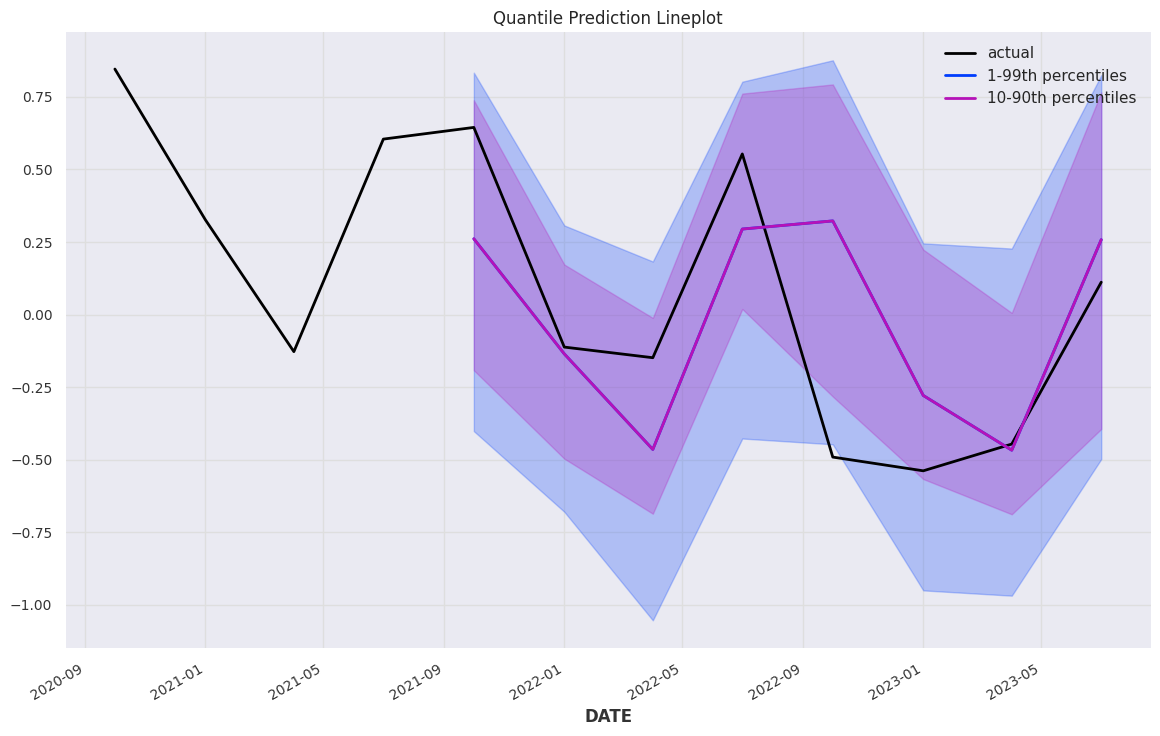

In [ ]:
# Calculate the start time for the plot
plot_start_time = forecast.start_time() - (forecast.freq * (4))

# Slicing the actual series to the relevant range
series_transformed_sliced = st.slice(plot_start_time, forecast.end_time())

# plot actual series
plt.figure(figsize=figsize)
series_transformed_sliced.plot(label="actual")

# plot prediction with quantile ranges
forecast.plot(low_quantile=lowest_q, high_quantile=highest_q, label=label_q_outer)
forecast.plot(low_quantile=low_q, high_quantile=high_q, label=label_q_inner)

plt.title("Quantile Prediction Lineplot")
plt.legend()
plt.show()

In [ ]:
print(f"MAE: {mae(eval, forecast):.4f}")
print(f"MAPE: {mape(eval, forecast):.4f} %")
print(f"MSE: {mse(eval, forecast):.4f}")
print(f"RMSE: {rmse(eval, forecast):.4f}")

MAE: 0.2779
MAPE: 86.2296 %
MSE: 0.1333
RMSE: 0.3651


## Save Predictions

In [ ]:
main_prediction = forecast.quantile_timeseries(quantile=0.5)
df = main_prediction.pd_dataframe()
df=df.rename(columns={'ASIALNG_0.5': 'ASIALNG M TFT'})
df.to_excel("ASIALNG_M_TFT_forecast.xlsx", index=True)
df

component,ASIALNG M TFT
DATE,
2021-10-01,0.261121
2022-01-01,-0.135467
2022-04-01,-0.464725
2022-07-01,0.294724
2022-10-01,0.322770
2023-01-01,-0.278715
2023-04-01,-0.467399
2023-07-01,0.258168


In [ ]:
# Open a file in write mode
with open('ASIALNG M TFT Results.txt', 'w') as file:
    # Write the variables to the file
    file.write(f'{mae(eval, forecast):.4f}\n')
    file.write(f'{mape(eval, forecast):.4f}\n')
    file.write(f'{mse(eval, forecast):.4f}\n')
    file.write(f'{rmse(eval, forecast):.4f}\n')